In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


https://blog.naver.com/PostView.nhn?blogId=sw4r&logNo=221734454450&categoryNo=68&parentCategoryNo=0&viewDate=&currentPage=1&postListTopCurrentPage=&from=postList&userTopListOpen=true&userTopListCount=5&userTopListManageOpen=false&userTopListCurrentPage=1

https://github.com/lucidrains/vit-pytorch

F12 -> console탭 -> 하단 입력창

# 실행
var timer = setInterval(function(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}, 60*1000);
timer;

# 종료
clearInterval(timer);
timer;

In [ ]:
import sys
sys.path

['',
 '/env/python',
 '/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.6/dist-packages/IPython/extensions',
 '/root/.ipython']

In [ ]:
!pip -q install vit_pytorch linformer

In [ ]:
from __future__ import print_function

import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

from vit_pytorch.efficient import ViT

In [ ]:
print(f"Torch: {torch.__version__}")

Torch: 1.7.0+cu101


In [ ]:
# Training settings
batch_size = 64
epochs = 100
lr = 3e-5
gamma = 0.7
seed = 42

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [ ]:
os.makedirs('data', exist_ok=True)

In [ ]:
train_dir = 'data/train'
test_dir = 'data/test'

In [ ]:
with zipfile.ZipFile('/content/gdrive/MyDrive/VIT/data/train/train.zip') as train_zip:
    train_zip.extractall('data')
    
with zipfile.ZipFile('/content/gdrive/MyDrive/VIT/data/test/test.zip') as test_zip:
    test_zip.extractall('data')

In [ ]:
train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))
print(len(train_list), len(test_list))
print(train_list[0:10])

25000 12500
['data/train/dog.9777.jpg', 'data/train/cat.11017.jpg', 'data/train/cat.5764.jpg', 'data/train/cat.1668.jpg', 'data/train/dog.5261.jpg', 'data/train/cat.4936.jpg', 'data/train/cat.6780.jpg', 'data/train/cat.1935.jpg', 'data/train/cat.2126.jpg', 'data/train/cat.2753.jpg']


In [ ]:
# train_tmp = []
# for i in range(len(train_list)):
#   train_tmp.append((train_list[i], int(train_list[i].split('/')[-1].split('.')[1])))
# train_tmp[0:10]
# train_tmp.sort(key= lambda train_tmp: train_tmp[1])
# train_tmp[0:10]

In [ ]:
print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 25000
Test Data: 12500


In [ ]:
labels = [one.split('/')[-1].split('.')[0] for one in train_list]

labels[0:10]

['dog', 'cat', 'cat', 'cat', 'dog', 'cat', 'cat', 'cat', 'cat', 'cat']

[23655 15796   861  5391 21576 11965 11285 22119  6266]
fig Figure(1152x864), axes [[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2ce6a13ba8>


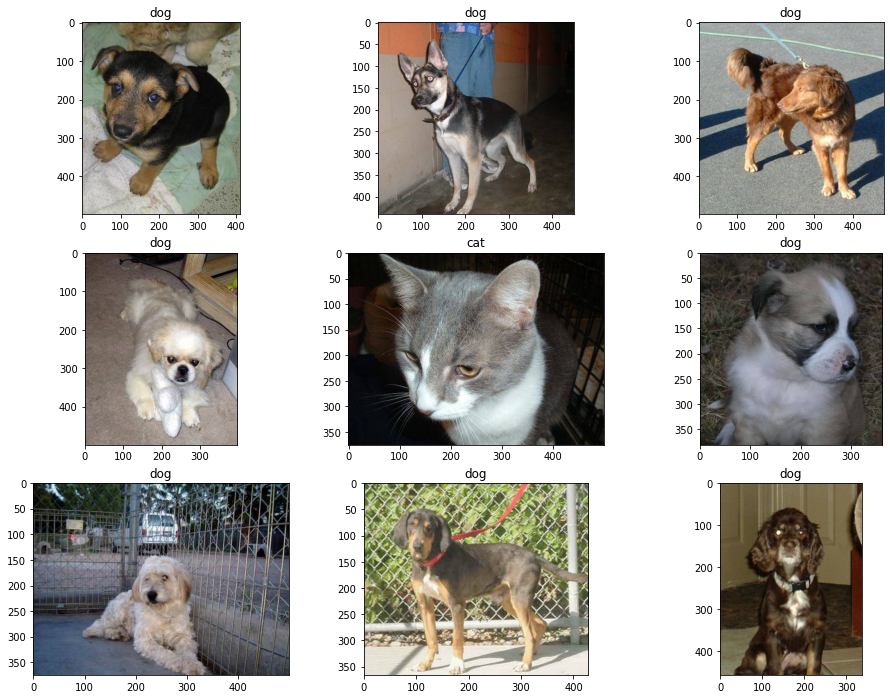

In [ ]:
random_idx = np.random.randint(1, len(train_list), size=9)
print(random_idx)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
print(f'fig {fig}, axes {axes}')

for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[random_idx[idx]])
    ax.set_title(labels[random_idx[idx]])
    ax.imshow(img)

In [ ]:
train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.2,
                                          stratify=labels,
                                          random_state=seed)
train_list[0:5]

['data/train/dog.316.jpg',
 'data/train/cat.7608.jpg',
 'data/train/dog.928.jpg',
 'data/train/dog.5148.jpg',
 'data/train/dog.10110.jpg']

In [ ]:
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 20000
Validation Data: 5000
Test Data: 12500


In [ ]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

In [ ]:
class CatsDogsDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)

        label = img_path.split("/")[-1].split(".")[0]
        label = 1 if label == "dog" else 0  # dog = 1, cat = 0

        return img_transformed, label


In [ ]:
train_data = CatsDogsDataset(train_list, transform=train_transforms)
valid_data = CatsDogsDataset(valid_list, transform=test_transforms)
test_data = CatsDogsDataset(test_list, transform=test_transforms)

In [ ]:
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

In [ ]:
train_data.__getitem__(0)

(tensor([[[0.3333, 0.3333, 0.3333,  ..., 0.2706, 0.2706, 0.2667],
          [0.3333, 0.3333, 0.3333,  ..., 0.2706, 0.2706, 0.2667],
          [0.3373, 0.3373, 0.3373,  ..., 0.2745, 0.2745, 0.2706],
          ...,
          [0.4431, 0.4471, 0.4471,  ..., 0.4588, 0.4588, 0.4549],
          [0.4431, 0.4471, 0.4471,  ..., 0.4588, 0.4588, 0.4549],
          [0.4431, 0.4471, 0.4471,  ..., 0.4588, 0.4588, 0.4549]],
 
         [[0.2588, 0.2588, 0.2588,  ..., 0.4627, 0.4627, 0.4588],
          [0.2588, 0.2588, 0.2588,  ..., 0.4627, 0.4627, 0.4588],
          [0.2627, 0.2627, 0.2627,  ..., 0.4588, 0.4588, 0.4588],
          ...,
          [0.2824, 0.2784, 0.2824,  ..., 0.4588, 0.4588, 0.4549],
          [0.2824, 0.2784, 0.2824,  ..., 0.4588, 0.4588, 0.4549],
          [0.2824, 0.2784, 0.2824,  ..., 0.4588, 0.4588, 0.4549]],
 
         [[0.1922, 0.1922, 0.1922,  ..., 0.4863, 0.4863, 0.4863],
          [0.1922, 0.1922, 0.1922,  ..., 0.4863, 0.4863, 0.4863],
          [0.1961, 0.1961, 0.1961,  ...,

In [ ]:
print(len(train_data), len(train_loader))
print(len(valid_data), len(valid_loader))

20000 313
5000 79


In [ ]:
efficient_transformer = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

In [ ]:
# device = 'cpu'
device = 'cuda:0'
# device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [ ]:
model = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=2,
    transformer=efficient_transformer,
    channels=3,
).to(device)

In [ ]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [ ]:
model.train()

ViT(
  (patch_to_embedding): Linear(in_features=3072, out_features=128, bias=True)
  (transformer): Linformer(
    (net): SequentialSequence(
      (layers): ModuleList(
        (0): ModuleList(
          (0): PreNorm(
            (fn): LinformerSelfAttention(
              (to_q): Linear(in_features=128, out_features=128, bias=False)
              (to_k): Linear(in_features=128, out_features=128, bias=False)
              (to_v): Linear(in_features=128, out_features=128, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
              (to_out): Linear(in_features=128, out_features=128, bias=True)
            )
            (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          )
          (1): PreNorm(
            (fn): FeedForward(
              (w1): Linear(in_features=128, out_features=512, bias=True)
              (act): GELU()
              (dropout): Dropout(p=0.0, inplace=False)
              (w2): Linear(in_features=512, out_features=128, bias=T

In [ ]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )



Epoch : 1 - loss : 0.6962 - acc: 0.5041 - val_loss : 0.6923 - val_acc: 0.4980




Epoch : 2 - loss : 0.6907 - acc: 0.5275 - val_loss : 0.6850 - val_acc: 0.5485




Epoch : 3 - loss : 0.6831 - acc: 0.5558 - val_loss : 0.6759 - val_acc: 0.5777




Epoch : 4 - loss : 0.6744 - acc: 0.5765 - val_loss : 0.6697 - val_acc: 0.5850




Epoch : 5 - loss : 0.6715 - acc: 0.5782 - val_loss : 0.6628 - val_acc: 0.5870




Epoch : 6 - loss : 0.6594 - acc: 0.5975 - val_loss : 0.6481 - val_acc: 0.6171




Epoch : 7 - loss : 0.6501 - acc: 0.6102 - val_loss : 0.6510 - val_acc: 0.6021




Epoch : 8 - loss : 0.6409 - acc: 0.6198 - val_loss : 0.6354 - val_acc: 0.6242




Epoch : 9 - loss : 0.6364 - acc: 0.6306 - val_loss : 0.6296 - val_acc: 0.6414




Epoch : 10 - loss : 0.6302 - acc: 0.6369 - val_loss : 0.6189 - val_acc: 0.6477




Epoch : 11 - loss : 0.6190 - acc: 0.6495 - val_loss : 0.6190 - val_acc: 0.6541




Epoch : 12 - loss : 0.6196 - acc: 0.6495 - val_loss : 0.6091 - val_acc: 0.6590




Epoch : 13 - loss : 0.6140 - acc: 0.6583 - val_loss : 0.6084 - val_acc: 0.6572




Epoch : 14 - loss : 0.6064 - acc: 0.6635 - val_loss : 0.6099 - val_acc: 0.6665




Epoch : 15 - loss : 0.6061 - acc: 0.6613 - val_loss : 0.6002 - val_acc: 0.6737




Epoch : 16 - loss : 0.5998 - acc: 0.6719 - val_loss : 0.6114 - val_acc: 0.6588




Epoch : 17 - loss : 0.5972 - acc: 0.6732 - val_loss : 0.5870 - val_acc: 0.6893




Epoch : 18 - loss : 0.5962 - acc: 0.6697 - val_loss : 0.5857 - val_acc: 0.6826




Epoch : 19 - loss : 0.5917 - acc: 0.6789 - val_loss : 0.5852 - val_acc: 0.6863




Epoch : 20 - loss : 0.5917 - acc: 0.6736 - val_loss : 0.5948 - val_acc: 0.6774




Epoch : 21 - loss : 0.5867 - acc: 0.6806 - val_loss : 0.5861 - val_acc: 0.6828




Epoch : 22 - loss : 0.5833 - acc: 0.6845 - val_loss : 0.5846 - val_acc: 0.6885




Epoch : 23 - loss : 0.5820 - acc: 0.6861 - val_loss : 0.5845 - val_acc: 0.6869




Epoch : 24 - loss : 0.5789 - acc: 0.6912 - val_loss : 0.5798 - val_acc: 0.6820




Epoch : 25 - loss : 0.5798 - acc: 0.6859 - val_loss : 0.5801 - val_acc: 0.6944




Epoch : 26 - loss : 0.5787 - acc: 0.6898 - val_loss : 0.5781 - val_acc: 0.6909




Epoch : 27 - loss : 0.5765 - acc: 0.6945 - val_loss : 0.5796 - val_acc: 0.6883




Epoch : 28 - loss : 0.5735 - acc: 0.6937 - val_loss : 0.5789 - val_acc: 0.6920




Epoch : 29 - loss : 0.5740 - acc: 0.6919 - val_loss : 0.5791 - val_acc: 0.6857




Epoch : 30 - loss : 0.5718 - acc: 0.6950 - val_loss : 0.5761 - val_acc: 0.6930




Epoch : 31 - loss : 0.5693 - acc: 0.6950 - val_loss : 0.5694 - val_acc: 0.6974




Epoch : 32 - loss : 0.5666 - acc: 0.7023 - val_loss : 0.5681 - val_acc: 0.7077




Epoch : 33 - loss : 0.5631 - acc: 0.7047 - val_loss : 0.5703 - val_acc: 0.6960




Epoch : 34 - loss : 0.5661 - acc: 0.7007 - val_loss : 0.5689 - val_acc: 0.6974




Epoch : 35 - loss : 0.5647 - acc: 0.7054 - val_loss : 0.5716 - val_acc: 0.7023




Epoch : 36 - loss : 0.5618 - acc: 0.7066 - val_loss : 0.5615 - val_acc: 0.7067




Epoch : 37 - loss : 0.5626 - acc: 0.7027 - val_loss : 0.5660 - val_acc: 0.7069




Epoch : 38 - loss : 0.5602 - acc: 0.7048 - val_loss : 0.5631 - val_acc: 0.6998




Epoch : 39 - loss : 0.5612 - acc: 0.7045 - val_loss : 0.5668 - val_acc: 0.6990




Epoch : 40 - loss : 0.5598 - acc: 0.7085 - val_loss : 0.5722 - val_acc: 0.6966




Epoch : 41 - loss : 0.5572 - acc: 0.7110 - val_loss : 0.5638 - val_acc: 0.7055




Epoch : 42 - loss : 0.5548 - acc: 0.7140 - val_loss : 0.5619 - val_acc: 0.7029




Epoch : 43 - loss : 0.5539 - acc: 0.7114 - val_loss : 0.5578 - val_acc: 0.7073




Epoch : 44 - loss : 0.5529 - acc: 0.7137 - val_loss : 0.5576 - val_acc: 0.7098




Epoch : 45 - loss : 0.5561 - acc: 0.7095 - val_loss : 0.5676 - val_acc: 0.7081




Epoch : 46 - loss : 0.5516 - acc: 0.7143 - val_loss : 0.5522 - val_acc: 0.7170




Epoch : 47 - loss : 0.5516 - acc: 0.7180 - val_loss : 0.5583 - val_acc: 0.7124




Epoch : 48 - loss : 0.5487 - acc: 0.7158 - val_loss : 0.5503 - val_acc: 0.7168




Epoch : 49 - loss : 0.5489 - acc: 0.7180 - val_loss : 0.5488 - val_acc: 0.7148




Epoch : 50 - loss : 0.5520 - acc: 0.7146 - val_loss : 0.5503 - val_acc: 0.7164




Epoch : 51 - loss : 0.5467 - acc: 0.7186 - val_loss : 0.5623 - val_acc: 0.7059




Epoch : 52 - loss : 0.5439 - acc: 0.7198 - val_loss : 0.5553 - val_acc: 0.7116




Epoch : 53 - loss : 0.5429 - acc: 0.7230 - val_loss : 0.5469 - val_acc: 0.7259




Epoch : 54 - loss : 0.5485 - acc: 0.7167 - val_loss : 0.5467 - val_acc: 0.7164




Epoch : 55 - loss : 0.5440 - acc: 0.7218 - val_loss : 0.5541 - val_acc: 0.7142




Epoch : 56 - loss : 0.5394 - acc: 0.7225 - val_loss : 0.5488 - val_acc: 0.7152




Epoch : 57 - loss : 0.5402 - acc: 0.7215 - val_loss : 0.5558 - val_acc: 0.7136




Epoch : 58 - loss : 0.5429 - acc: 0.7167 - val_loss : 0.5551 - val_acc: 0.7106




Epoch : 59 - loss : 0.5421 - acc: 0.7193 - val_loss : 0.5621 - val_acc: 0.7083




Epoch : 60 - loss : 0.5436 - acc: 0.7226 - val_loss : 0.5548 - val_acc: 0.7114




Epoch : 61 - loss : 0.5385 - acc: 0.7261 - val_loss : 0.5523 - val_acc: 0.7075




Epoch : 62 - loss : 0.5376 - acc: 0.7254 - val_loss : 0.5453 - val_acc: 0.7231




Epoch : 63 - loss : 0.5388 - acc: 0.7283 - val_loss : 0.5510 - val_acc: 0.7120




Epoch : 64 - loss : 0.5333 - acc: 0.7272 - val_loss : 0.5468 - val_acc: 0.7215




Epoch : 65 - loss : 0.5341 - acc: 0.7272 - val_loss : 0.5441 - val_acc: 0.7231




Epoch : 66 - loss : 0.5328 - acc: 0.7292 - val_loss : 0.5367 - val_acc: 0.7267




Epoch : 67 - loss : 0.5322 - acc: 0.7281 - val_loss : 0.5409 - val_acc: 0.7191




Epoch : 68 - loss : 0.5325 - acc: 0.7319 - val_loss : 0.5498 - val_acc: 0.7199




Epoch : 69 - loss : 0.5370 - acc: 0.7288 - val_loss : 0.5377 - val_acc: 0.7235




Epoch : 70 - loss : 0.5316 - acc: 0.7302 - val_loss : 0.5452 - val_acc: 0.7178




Epoch : 71 - loss : 0.5296 - acc: 0.7333 - val_loss : 0.5597 - val_acc: 0.7144




Epoch : 72 - loss : 0.5307 - acc: 0.7347 - val_loss : 0.5449 - val_acc: 0.7174




Epoch : 73 - loss : 0.5261 - acc: 0.7335 - val_loss : 0.5428 - val_acc: 0.7219




Epoch : 74 - loss : 0.5315 - acc: 0.7297 - val_loss : 0.5394 - val_acc: 0.7239




Epoch : 75 - loss : 0.5289 - acc: 0.7295 - val_loss : 0.5400 - val_acc: 0.7247




Epoch : 76 - loss : 0.5246 - acc: 0.7364 - val_loss : 0.5357 - val_acc: 0.7282




Epoch : 77 - loss : 0.5256 - acc: 0.7317 - val_loss : 0.5467 - val_acc: 0.7213




Epoch : 78 - loss : 0.5289 - acc: 0.7333 - val_loss : 0.5470 - val_acc: 0.7203




Epoch : 79 - loss : 0.5267 - acc: 0.7345 - val_loss : 0.5403 - val_acc: 0.7215




Epoch : 80 - loss : 0.5266 - acc: 0.7351 - val_loss : 0.5378 - val_acc: 0.7292




Epoch : 81 - loss : 0.5232 - acc: 0.7368 - val_loss : 0.5412 - val_acc: 0.7188




Epoch : 82 - loss : 0.5265 - acc: 0.7371 - val_loss : 0.5321 - val_acc: 0.7373




Epoch : 83 - loss : 0.5196 - acc: 0.7412 - val_loss : 0.5340 - val_acc: 0.7255




Epoch : 84 - loss : 0.5200 - acc: 0.7369 - val_loss : 0.5386 - val_acc: 0.7259




Epoch : 85 - loss : 0.5191 - acc: 0.7384 - val_loss : 0.5266 - val_acc: 0.7310




Epoch : 86 - loss : 0.5198 - acc: 0.7381 - val_loss : 0.5386 - val_acc: 0.7227




Epoch : 87 - loss : 0.5203 - acc: 0.7394 - val_loss : 0.5280 - val_acc: 0.7350




Epoch : 88 - loss : 0.5167 - acc: 0.7401 - val_loss : 0.5351 - val_acc: 0.7277




Epoch : 89 - loss : 0.5152 - acc: 0.7425 - val_loss : 0.5280 - val_acc: 0.7314




Epoch : 90 - loss : 0.5187 - acc: 0.7375 - val_loss : 0.5316 - val_acc: 0.7302




Epoch : 91 - loss : 0.5185 - acc: 0.7400 - val_loss : 0.5337 - val_acc: 0.7284




Epoch : 92 - loss : 0.5095 - acc: 0.7450 - val_loss : 0.5292 - val_acc: 0.7302




Epoch : 93 - loss : 0.5157 - acc: 0.7416 - val_loss : 0.5295 - val_acc: 0.7278




Epoch : 94 - loss : 0.5151 - acc: 0.7394 - val_loss : 0.5309 - val_acc: 0.7328




Epoch : 95 - loss : 0.5097 - acc: 0.7437 - val_loss : 0.5287 - val_acc: 0.7294




Epoch : 96 - loss : 0.5134 - acc: 0.7452 - val_loss : 0.5399 - val_acc: 0.7263




Epoch : 97 - loss : 0.5074 - acc: 0.7495 - val_loss : 0.5235 - val_acc: 0.7312




Epoch : 98 - loss : 0.5116 - acc: 0.7463 - val_loss : 0.5330 - val_acc: 0.7278




Epoch : 99 - loss : 0.5050 - acc: 0.7498 - val_loss : 0.5243 - val_acc: 0.7346




Epoch : 100 - loss : 0.5035 - acc: 0.7498 - val_loss : 0.5384 - val_acc: 0.7227



In [ ]:
model.load_state_dict(model.state_dict())

<All keys matched successfully>

In [ ]:
os.makedirs('/content/gdrive/MyDrive/VIT/trained_model', exist_ok=True)

In [ ]:
path = '/content/gdrive/MyDrive/VIT/trained_model/'
torch.save(model.state_dict(), path + 'model_state_100.pt')
torch.save(model, path + 'model_100.pt')

In [ ]:
model.eval()

ViT(
  (patch_to_embedding): Linear(in_features=3072, out_features=128, bias=True)
  (transformer): Linformer(
    (net): SequentialSequence(
      (layers): ModuleList(
        (0): ModuleList(
          (0): PreNorm(
            (fn): LinformerSelfAttention(
              (to_q): Linear(in_features=128, out_features=128, bias=False)
              (to_k): Linear(in_features=128, out_features=128, bias=False)
              (to_v): Linear(in_features=128, out_features=128, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
              (to_out): Linear(in_features=128, out_features=128, bias=True)
            )
            (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          )
          (1): PreNorm(
            (fn): FeedForward(
              (w1): Linear(in_features=128, out_features=512, bias=True)
              (act): GELU()
              (dropout): Dropout(p=0.0, inplace=False)
              (w2): Linear(in_features=512, out_features=128, bias=T

In [ ]:
model100 = torch.load('/content/gdrive/MyDrive/VIT/trained_model/model_100.pt')
model100_s = torch.load('/content/gdrive/MyDrive/VIT/trained_model/model_state_100.pt')
model20 = torch.load('/content/gdrive/MyDrive/VIT/trained_model/model_20.pt')
model20_s = torch.load('/content/gdrive/MyDrive/VIT/trained_model/model_state_20.pt')

In [ ]:
model.load_state_dict(model100_s)

<All keys matched successfully>

In [ ]:
import numpy as np
test_img = Image.open('/content/gdrive/MyDrive/VIT/data/cat_test1.jpg', mode='r')
print(f'{type(test_img)}')
test_img_np = np.array(test_img)
print(test_img_np.shape)
test_img = transforms.ToTensor()(test_img).to(device) # Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255]
                                                      # to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0] 
print(f'{type(test_img)}, {test_img.shape}')
# test_img = F.interpolate(test_img, size=224)
# print(f'{type(test_img)}, {test_img.shape}')


# test_img =  torch.from_numpy(test_img_np)
# test_img.shape
# test_img = test_img.unsqueeze(0)
# test_img.shape

<class 'PIL.JpegImagePlugin.JpegImageFile'>
(340, 340, 3)
<class 'torch.Tensor'>, torch.Size([3, 340, 340])


In [ ]:
test_img

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]], device='cuda:0')

In [ ]:
test_img = test_img.unsqueeze(0)
# test_img = np.transpose(test_img, (0, 1, 2, 3)) # 그대로
test_img.shape

torch.Size([1, 3, 340, 340])

In [ ]:
test_img = F.interpolate(test_img, size= (224,224)) 
test_img.shape

torch.Size([1, 3, 224, 224])

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py

In [ ]:
model(test_img)

tensor([[-0.0018, -0.4084]], device='cuda:0', grad_fn=<AddmmBackward>)